#  Logistic Regression and Classification Error Metrics

# NOMES:
    SAMIR TUFFI SALIBA JUNIOR
    JÂNIO PRATES OTONI

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
data_path = ['data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

Como se pode ver abaixo, os dados das colunas são todos tipo float exceto a coluna da atividade, que é o label

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

Os dados estão normalizados entre -1 (mínimo) e 1.0 (máximo).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examinando a ocorrência de cada classe (cada atividade diferente) pode-se perceber que elas estão razoavelmente balanceadas, isto é, todas as classes estão bem representadas no conjunto de dados.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

A coluna de atividades deve ser transformada de nomes (strings) para inteiros, para que os classificadores do Scikit learn aceitem a matriz de entrada. O 'LabelEncoder' codifica as labels (atividades) em inteiros, como se pode ver abaixo.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

3083    2
2933    1
479     4
460     3
6630    2
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

Abaixo, são calculados os valores de correlação entre as variáveis independentes (as features). Analisar as correlações é importante para o processo de escolher as features para o modelo: features que são altamente correlacionadas vão ter impacto semelhante no modelo; pode-se, então, remover uma das features para melhorias no desempenho do modelo.

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

Calculados os coeficientes, um histograma é criado para visualização da correlação entre os dados.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

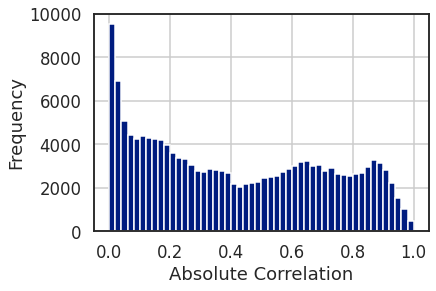

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

Podemos ver todas as features que tem correlação forte entre si, isto é, com coeficiente de correlação absoluto (positivo ou negativo) acima de 0.8.

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


Então, os dados são divididos entre conjunto de treino e conjunto de teste. O uso da classe StratifiedShuffleSplit é fundamental: o método dessa classe divide os conjuntos respeitando a proporção das classes no conjunto de dados, garantindo que as diferentes classes estão bem representadas tanto no conjunto de teste quanto no conjunto de treino. Além disso, o método também embaralha os dados, para que não haja nenhum viés da ordem de treino.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(7209, 561)
(7209,)
(3090, 561)
(3090,)


Perceba as proporções de cada classe (6 classes, de 0 a 5) nos conjuntos de treino e teste, respectivamente. Como explicado anteriormente, StratifiedShuffleSplit manteve as proporções nos dois conjuntos.

In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

# Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

Abaixo, utilizamos o modelo de regressão logística padrão do Sklearn, apenas alterando o número máximo de iterações (max_iter) no construtor da classe para evitar um erro de não convergência do lbfgs. 
Por padrão, os parâmetros escolhidos são:  
Penalidade: L2.  
Solver: LBFGS.  
Ref: documentação do Scikit learn.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)

Agora, utilizando o modelo de regressão logística com validação cruzada.  
O método padrão da cross-validação utilizado pela classe LogisticRegressionCV é o Stratified K-Folds, que subdivide o conjunto de treino em "K" subconjuntos respeitando novamente as proporções de cada classe. Por isso o nome Stratified K-Folds. No parâmetro cv, o inteiro representa o valor de "K" vezes que o conjunto de treino será dividido.  
Pode-se notar também a penalidade: L1

De acordo com a documentação do Scikitlearn para a classe LogisticRegressionCV:
> solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’  
Algorithm to use in the optimization problem.  
- For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
- For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
- ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
- ‘liblinear’ might be slower in LogisticRegressionCV because it does not handle warm-starting.  
Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.  
New in version 0.17: Stochastic Average Gradient descent solver.  
New in version 0.19: SAGA solver.

Por se tratar de uma base de dados de tamanho relativamente grande em relação ao meu computador pessoal, dei preferência para os solvers SAGA e SAG para os casos de penalização l1 e l2, respectivamente.


In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(max_iter=100, Cs=10, cv=4, penalty='l1', solver='saga').fit(X_train, y_train)

/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter wa

In [18]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

Assim como o modelo anterior, mas agora mudando a penalidade para l2, que penaliza coeficientes maiores mais severamente, devido ao expoente quadrado na função de custo.

In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(max_iter=100, Cs=10, cv=4, penalty='l2').fit(X_train, y_train)

/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

Os coeficientes dos modelos podem ser visualizados, em um dataframe.

In [20]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
133 -0.016081  0.079157  0.025177  0.381352 -0.114961 -0.354644  0.010853   
342  0.032186  0.010535  0.006652  0.022843 -0.057696 -0.014520  0.005298   
529  0.009131  0.052123 -0.190460  0.076369  0.058036 -0.005199  0.004579   
14   0.026929  0.361035 -0.198521  0.049765 -0.199866 -0.039342  0.023446   
153  0.075179  0.002163  0.099653 -0.204164 -0.315239  0.342408  0.063399   
108 -0.068950 -0.133351  0.330787  0.278559 -0.460689  0.053644 -0.019079   
238 -0.002996  0.241267 -0.112702  0.147571 -0.339635  0.066496  0.054537   
141 -0.023510  0.152896 -0.275796 -0.730432  0.137362  0.739479 -0.033005   
456  0.163917 -0.053370 -0.236894  0.126182 -0.396728  0.396892  0.337723   
101 -0.021182  0.084936 -0.193150  0.168639  0.147951 -0.187194 -0.052523   

                                                             l2            \
            1         2         3         4         5         0         1   
133  0.060068 -0.052500  0.376642 -0.059463 -0.306929  0.023208  0.095964   
342  0.007254  0.034918 -0.005300 -0.015855 -0.011543  0.012906  0.030746   
529  0.197926 -0.275154  0.042925  0.043413 -0.022967  0.000360  0.146051   
14   0.484503 -0.373948  0.037238 -0.261983  0.033057  0.054519  0.538114   
153 -0.004422  0.098766 -0.178985 -0.359922  0.379413  0.088668  0.015835   
108 -0.240424  0.475584  0.184911 -0.774210  0.133750 -0.057774 -0.190038   
238  0.302950 -0.214428  0.213663 -0.444524  0.065745  0.024036  0.313446   
141  0.281131 -0.305378 -0.922800  0.188160  2.123448 -0.065360  0.281249   
456 -0.310578 -0.342580  0.061371 -0.447676  0.232026  0.263006 -0.187664   
101  0.104622 -0.094063  0.104258  0.105002 -0.170486 -0.075175  0.149734   

                                             
            2         3         4         5  
133 -0.050565  0.515403 -0.123523 -0.460488  
342  0.052746  0.015428 -0.083103 -0.028723  
529 -0.275184  0.082581  0.073837 -0.027645  
14  -0.374464  0.064363 -0.253669 -0.028864  
153  0.159738 -0.286233 -0.409361  0.431353  
108  0.408337  0.341231 -0.587796  0.086040  
238 -0.191955  0.222250 -0.458522  0.090743  
141 -0.367056 -0.971769  0.195075  0.927861  
456 -0.250225  0.150316 -0.449714  0.474282  
101 -0.193463  0.185280  0.173619 -0.239995

E podem ser visualizados em gráficos separadamente:

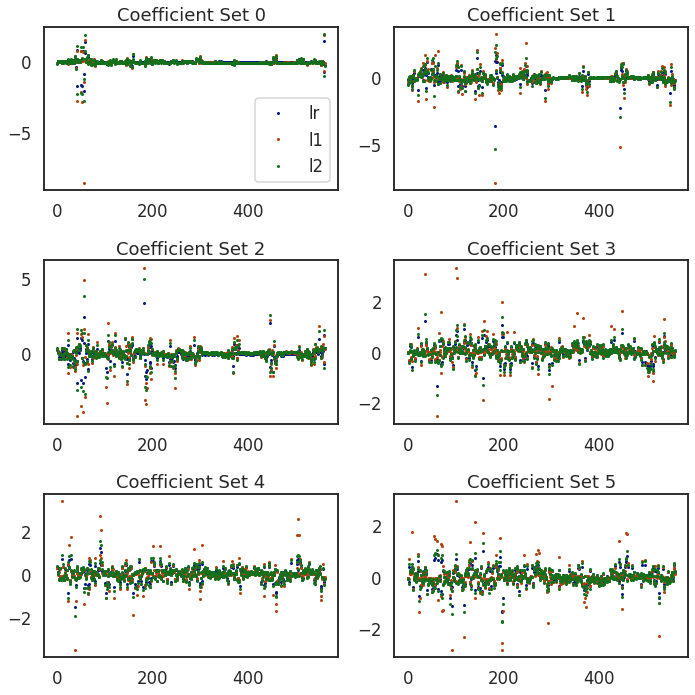

In [21]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

Utilizando os modelos para predição das classes e armazenando os resultados (y_pred) e as probabilidades (y_prob) dadas para as classes:

In [22]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [23]:
y_prob.head()

,lr,l1,l2
0,0.999987,1.000000,0.999997
1,0.998374,0.999976,0.999691
2,0.996554,0.999879,0.998947
3,0.990812,0.999633,0.997620
4,0.998116,0.999629,0.999421


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

São calculadas então as seguintes métricas de erro para cada modelo diferente:
- Acurácia
- Precisão
- Recall
- Fscore
- Matriz de confusão

In [24]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


Visualizando o resultado das métricas para os três modelos diferentes:

In [25]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.983811,0.983810,0.983484
recall,0.983819,0.983819,0.983495
fscore,0.983811,0.983812,0.983489
accuracy,0.983819,0.983819,0.983495
auc,0.990184,0.990162,0.989975


## Question 8

Display or plot the confusion matrix for each model.

Apresentando a matriz de confusão para os três modelos:

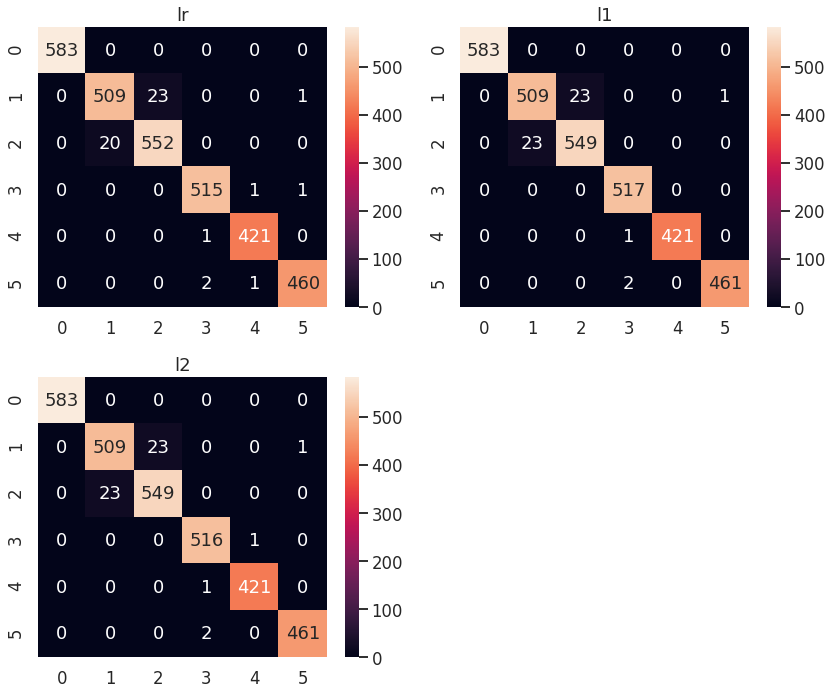

In [26]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

Uma questão fundamental para os modelos de Machine Learning é a seleção das features. Como vimos anteriormente, há várias features fortemente relacionadas no modelo, e uma estratégia interessante é retirar as features que estão fortemente relacionadas entre si (retirar apenas uma delas, no caso), já que tem impacto semelhante no modelo.

De acordo com a definição da classe VarianceThreshold, na documentação do Scikit Learn:
> Feature selector that removes all low-variance features.  

Ou seja, a classe remove as features que apresentam baixa variância. O threshold (limiar) pode ser passado no construtor.

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler


X_data = data.iloc[:, :-1]

#threshold with .7
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]

# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features

X_train_new = X_data.loc[train_idx, :]
y_train_new = data.loc[train_idx, 'Activity']

X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']

print(X_train.shape)
print(X_train_new.shape)

print(X_test.shape)
print(X_test_new.shape)

(7209, 561)
(7209, 91)
(3090, 561)
(3090, 91)


Repetindo os modelos agora com o novo conjuntod e treino, após remoção das features acima.

In [28]:
lr = LogisticRegression(max_iter=100).fit(X_train_new, y_train)

lr_l1 = LogisticRegressionCV(max_iter=100, Cs=10, cv=4, penalty='l1', solver='saga').fit(X_train_new, y_train)

lr_l2 = LogisticRegressionCV(max_iter=100, Cs=10, cv=4, penalty='l2', solver='lbfgs').fit(X_train_new, y_train)

/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/samir/.local/lib/python3.8/site-pa

/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/samir/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

In [29]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [30]:
# Combine all the coefficients into a dataframe for comparison
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.head()

lr                                                          l1  \
          0         1         2         3         4         5         0   
0 -0.063672 -0.476753 -0.005792 -0.634079  0.722913  0.457383 -0.062498   
1 -0.157524  0.177114 -0.475716 -0.033942 -0.743781  1.233848 -0.043593   
2  0.006217 -0.210440  0.211631  0.153024 -1.426048  1.265615  0.064718   
3 -0.057947 -0.367015 -0.013692 -0.262499  0.948840 -0.247688 -0.053009   
4 -0.154274  0.150672 -0.370182  0.210685 -0.829195  0.992294 -0.057076   

                                                           l2            \
          1         2         3         4         5         0         1   
0 -0.695205 -0.483868 -1.392715  0.737551  1.935166 -0.308988 -0.904732   
1  0.744259 -1.223400  0.673837 -2.477456  2.016075 -0.231253  1.100338   
2 -0.747263  1.065995  0.313501 -5.850002  5.440663  0.287094 -0.404834   
3  0.086339 -0.818570 -0.724197  5.003536 -1.587595 -0.272715  0.988270   
4  0.547022 -0.668612  1.244548 -0.643967 -0.604623 -0.295214  1.449813   

                                           
          2         3         4         5  
0 -1.859443 -3.545867  2.064511  4.554519  
1 -1.517762  0.860845 -4.912668  4.700501  
2  0.421280 -0.041430 -8.499511  8.237402  
3 -3.317659 -1.827501  9.972495 -5.542890  
4 -1.474542  1.163084  1.222892 -2.066032

Prepare six separate plots for each of the multi-class coefficients.

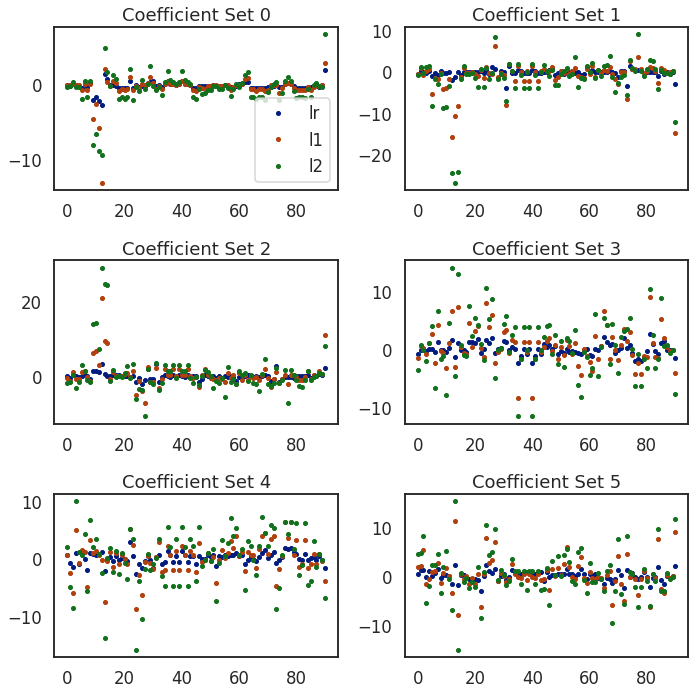

In [31]:
# try the plots
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=4.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [32]:
# Predict the class and the probability for each
y_pred_new = list()
y_prob_new = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

y_pred_new.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [33]:
# Calculate the error metrics as listed above
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics_new = list()
cm_new = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred_new[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_new[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred_new[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm_new[lab] = confusion_matrix(y_test, y_pred_new[lab])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics_new = pd.concat(metrics_new, axis=1)

In [34]:
#Run the metrics
metrics_new

,lr,l1,l2
precision,0.947978,0.960561,0.963228
recall,0.947896,0.960518,0.963107
fscore,0.947861,0.960482,0.963074
accuracy,0.947896,0.960518,0.963107
auc,0.968521,0.976103,0.977709


## Question 13

Display or plot the confusion matrix for each model.

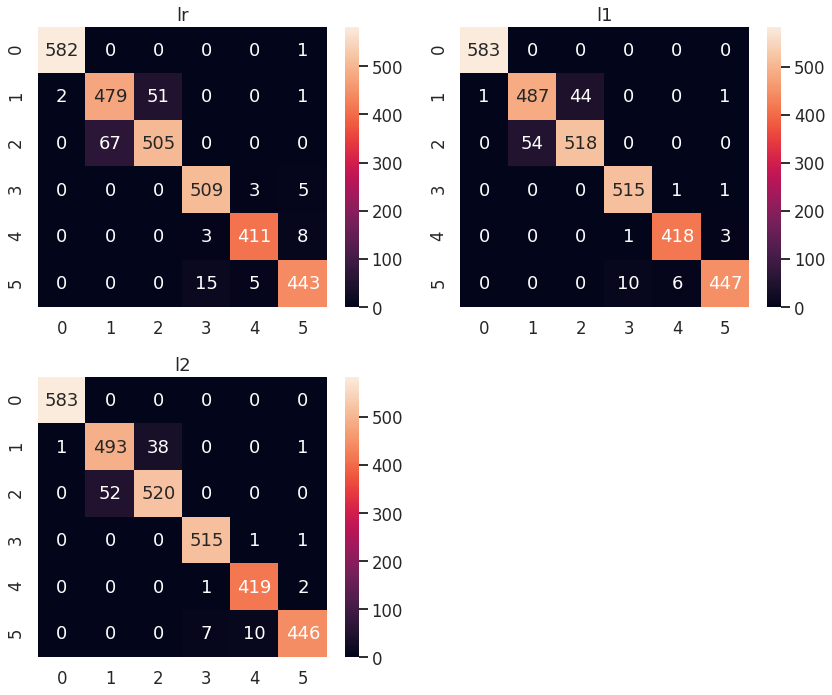

In [35]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [36]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation
metrics

,lr,l1,l2
precision,0.983811,0.983810,0.983484
recall,0.983819,0.983819,0.983495
fscore,0.983811,0.983812,0.983489
accuracy,0.983819,0.983819,0.983495
auc,0.990184,0.990162,0.989975


In [37]:
metrics_new

,lr,l1,l2
precision,0.947978,0.960561,0.963228
recall,0.947896,0.960518,0.963107
fscore,0.947861,0.960482,0.963074
accuracy,0.947896,0.960518,0.963107
auc,0.968521,0.976103,0.977709


### Como se pode ver acima, houve uma queda geral em todas as métricas. Entretanto, a redução de custo (e de tempo de treino) foi extremamente significante, pois as features foram reduzidas de 561 para apenas 50. É interessante, então, a ideia de ajustar a quantidade de features para encontrar um ponto ideal no tradeoff velocidade, custo x qualidade do modelo.

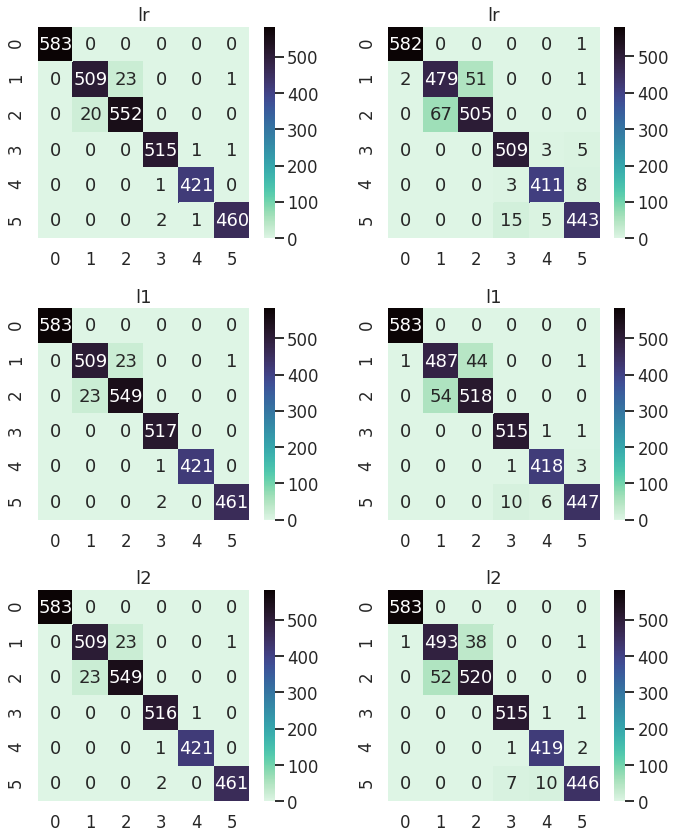

In [38]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 12)

cm_list = [cm, cm_new]
i=0

for lab in coeff_labels:
    for conf_mtx in cm_list:
        sns.heatmap(conf_mtx[lab], ax=axList[i], cbar=True, cmap='mako_r', square=True, annot=True, fmt='d');
        axList[i].set(title=lab);
        i+=1
plt.tight_layout()


À esquerda, matrizes de confusão para os modelos com todas as 561 features. À direita, matrizes de confusão para os modelos após o feature selecting.

### Percebe-se pelas matrizes de confusão o mesmo raciocínio sobre as métricas: o modelo perdeu qualidade de classificação, embora ainda tenha apresentado bons resultados.  
### Uma hipótese é que os erros foram acentuados, pois estão localizados em grande parte nos mesmos locais que estavam anteriormente, embora estejam agora em maior quantidade. Pode-se inferir que algumas features valiosas foram retiradas e que a incerteza nas classificações também aumentou.

In [39]:
y_prob.mean(axis=0)

lr    0.972271
l1    0.984756
l2    0.979893
dtype: float64

In [40]:
y_prob_new.mean(axis=0)

lr    0.918705
l1    0.955650
l2    0.963405
dtype: float64

### Como inferido anteriormente, a confiança nas classificações realmente diminuiu.

In [41]:
diff_confianca = y_prob.subtract(y_prob_new)
diff_confianca.mean(axis=0)

lr    0.053565
l1    0.029105
l2    0.016488
dtype: float64